In [159]:
import numpy as np 
import numba as nb
from matplotlib import pyplot as plt

## Canvas + Camera

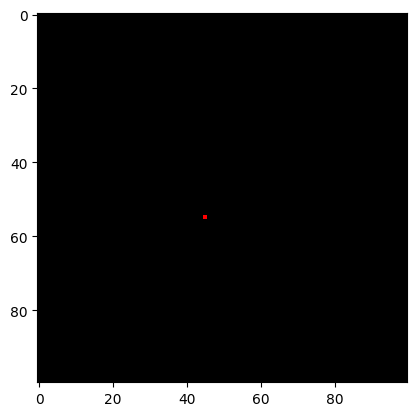

In [286]:
camera = {
    
    "position": (0,0,0),
    "orientation": [[1,0,0],[0,1,0],[0,0,1]],
    "d": 1,
    "w": 1,
    "h": 1,

    "canvas" : {
        "resolution":(100,100),
        "pixels": None,
    }
}

def initialize_camera(camera):
    resolution = camera["canvas"]["resolution"]
    camera["canvas"]["pixels"] = np.zeros((resolution[0], resolution[1], 3))
    return camera


@nb.njit()
def center2pixel(resolution, x, y):
    return (int(resolution[0]//2) - y, int(resolution[1]//2) + x)

@nb.njit()
def write_pixel(pixels, resolution, x, y, color):
    x,y = center2pixel(resolution, x,y)
    pixels[x][y] = color

    return color

def show(canvas):
    plt.imshow(canvas["pixels"])
    plt.show()

@nb.njit()
def canvas2world(x,y, resolution, w, h, d):
    return (x*w/resolution[0], y*h/resolution[1], d)


camera = initialize_camera(camera)

write_pixel(camera['canvas']['pixels'], camera['canvas']['resolution'], -5, -5, np.array([1,0,0]))

show(camera["canvas"])


## Lights

In [161]:
lights = [
    {"type":"PointLight", "position": np.array([0, 0, 0.5]), "intensity": 1},
]

@nb.njit()
def get_L_point_light(P, light_position):
    return light_position - P

@nb.njit()
def get_L(P, light_position, light_type):
    if light_type == "PointLight":
        return get_L_point_light(P, light_position) 
    else:
        raise Exception("Light type not implemented")


light = lights[0]
get_L(np.array([0,0,1]), light["position"], light["type"])

array([ 0. ,  0. , -0.5])

## Materials

In [162]:
class PhongMaterial():
    def __init__(self, color, ambient=0.4, specular=0.9, reflective=0.2):
        self.color = np.array(color)
        self.ambient = ambient
        self.specular = specular
        self.reflective = reflective

## Rays

In [163]:
ray = {"origin": np.array([0, 0, 0]), 
       "direction": np.array([1, 0, 0]),
       "tmin": 0,
       "tmax":np.inf}

@nb.njit()
def p(ray_origin, ray_direction, t):
    return ray_origin + ray_direction * t

## Primitives

In [164]:
@nb.njit()
def intersect_sphere(sphere_position, sphere_radius, ray_origin, ray_direction):
    ray_dot = ray_direction[0]**2+ray_direction[1]**2+ray_direction[2]**2
    a = ray_dot


    delta = ray_origin-sphere_position
    delta_ray_dot = delta[0]*ray_direction[0]+delta[1]*ray_direction[1]+delta[2]*ray_direction[2]
    b = 2*delta_ray_dot
    
    delta_dot = delta[0]**2+delta[1]**2+delta[2]**2
    c = delta_dot - sphere_radius**2

    discriminant = b**2 - 4*a*c

    if discriminant < 0:
        return [np.inf]
    else:
        t1 = (-b - np.sqrt(discriminant))/(2*a)
        t2 = (-b + np.sqrt(discriminant))/(2*a)
        return [t1,t2]


@nb.njit()
def normal_sphere(point, sphere_position, sphere_radius):
    return (point-sphere_position)/sphere_radius


intersect_sphere(np.array([0,0,0]), 1, np.array([0,0,-3]), np.array([0,0,1]))

normal_sphere(np.array([0,0,0]), np.array([0,0,0]), 1)


array([0., 0., 0.])

In [639]:
@nb.njit()
def closest_intersection(ray_origin, ray_direction, ray_tmin, ray_tmax, spheres):
    closest_index = -1
    closest_t = np.inf
    closest_sphere_position = np.array([0,0,0], dtype=np.float64)
    closest_sphere_radius = -1
    closest_sphere_inside = 0
    
    for i,sphere in enumerate(spheres):
        sphere_position = sphere[:3]
        sphere_radius = sphere[3]
        ts = intersect_sphere(sphere_position, sphere_radius, ray_origin, ray_direction)

        for t in ts:
            if (ray_tmin < t < ray_tmax) and t < closest_t:
                closest_index = i
                closest_t = t
                closest_sphere_position = sphere_position
                closest_sphere_radius = sphere_radius

    if closest_sphere_radius == -1:
        return [-9999., -9999., -9999., -9999., -9999., -9999.]
    
    else:
        
        d = ray_origin-closest_sphere_position
        closest_sphere_inside = d[0]**2+d[1]**2+d[2]**2 <= closest_sphere_radius**2+0.001

        return [closest_t, 
                closest_sphere_position[0],
                closest_sphere_position[1],
                closest_sphere_position[2],
                closest_sphere_radius,
                closest_sphere_inside,
                closest_index]


closest_intersection(np.array([0,0,0]), 
                     np.array([0,0,1]), 
                     0, 
                     np.inf, np.array([[0,0,1.5, 1.]]))


[0.5, 0.0, 0.0, 1.5, 1.0, 0.0, 0.0]

In [195]:
@nb.njit()
def t(a,b,c,d,e):
    if a>0:
        return [0,0,0,0,0]
    else:
        return [a,b,c,d,e]


t(1,2,3,4,5)
    

[0, 0, 0, 0, 0]

In [166]:
@nb.njit()
def hemisphere2world(theta,phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.cos(theta)
    z = np.sin(theta)*np.sin(phi)
    return np.array([x,y,z])


hemisphere2world(1, 1)

@nb.njit()
def sample_uniform_hemisphere(r1,r2):
    sin_theta = np.sqrt(1-r1**2)
    phi = 2*np.pi*r2

    x = sin_theta*np.cos(phi)
    y = r1 # cos(theta)
    z = sin_theta*np.sin(phi)

    return np.array([x,y,z])

sample_uniform_hemisphere(1, 1)

@nb.njit()
def create_local_coordinate_system(N):
    N_norm = np.sqrt(N[0]**2 + N[1]**2 + N[2]**2)
    if (N[0]>N[1]):
        Nt = np.array([N[2], 0, -N[0]]) / N_norm
    else:
        Nt = np.array([0, -N[2], N[1]]) / N_norm
    Nb = np.cross(N,Nt)

    return Nb, Nt, N


create_local_coordinate_system(np.array([1, 1, 1]))




@nb.njit()
def local2world(P_local, N_world):
    Nt, Nb, _ = create_local_coordinate_system(N_world)

    A = np.array([[Nb[0], N_world[0], Nt[0]],
                  [Nb[1], N_world[1], Nt[1]],
                  [Nb[2], N_world[2], Nt[2]]])

    C = np.zeros(3)
    for i in nb.prange(3):
        for j in nb.prange(3):
            C[i] += A[i,j] * P_local[j]

    return C


def local2world_np(P_local, N_world):
    Nt, Nb, _ = create_local_coordinate_system(N_world)

    A = np.array([[Nb[0], N_world[0], Nt[0]],
                  [Nb[1], N_world[1], Nt[1]],
                  [Nb[2], N_world[2], Nt[2]]])

    return np.matmul(A,P_local)

res1 = local2world_np(np.array([3,1,2]), np.array([4,5,1]))
res2 = local2world(np.array([3,1,2]), np.array([4,5,1]))


for i in range(3):
    assert res1[i] == res2[i]


In [629]:
from PIL import Image

skybox_image_cubemap = Image.open("skyboxes/miramar.jpeg")
skybox_image_cubemap = np.array(skybox_image_cubemap)


def split_cubemap(skybox_image, height, total_width):
    face_width = total_width // 4

    images = [
            skybox_image[face_width:2*face_width, 2*face_width:3*face_width], # POSITIVE X
            skybox_image[face_width:2*face_width, 0:face_width], # NEGATIVE X
            skybox_image[0:face_width, face_width:2*face_width], # POSITIVE Y
            skybox_image[2*face_width:3*face_width, face_width:2*face_width], # NEGATIVE Y
            skybox_image[face_width:2*face_width, face_width:2*face_width], # POSITIVE Z
            skybox_image[face_width:2*face_width, 3*face_width:4*face_width], # NEGATIVE Z
            ]
    
    return images

skybox_images = split_cubemap(skybox_image_cubemap, *skybox_image_cubemap.shape[:2])

skybox_images = np.array(skybox_images)

@nb.njit()
def sphere2pixel(P, image_height, image_width):
    x,y,z = P
    abs_x, abs_y, abs_z = np.abs(P)

    x_positive = x>0
    y_positive = y>0
    z_positive = z>0

    # POSITIVE X
    if x_positive and abs_x >= abs_y and abs_x >= abs_z:
        max_axis = abs_x
        uc = -z
        vc = y
        index = 0

    # NEGATIVE X
    if not x_positive and abs_x >= abs_y and abs_x >= abs_z:
        max_axis = abs_x
        uc = z
        vc = y
        index = 1
    
    # POSITIVE Y
    if y_positive and abs_y >= abs_x and abs_y >= abs_z:
        max_axis = abs_y
        uc = x
        vc = -z
        index = 2
    
    # NEGATIVE Y
    if not y_positive and abs_y >= abs_x and abs_y >= abs_z:
        max_axis = abs_y
        uc = x
        vc = z
        index = 3

    # POSITIVE Z
    if z_positive and abs_z >= abs_x and abs_z >= abs_y:
        max_axis = abs_z
        uc = x
        vc = y
        index = 4
    
    # NEGATIVE Z
    if not z_positive and abs_z >= abs_x and abs_z >= abs_y:
        max_axis = abs_z
        uc = -x
        vc = y
        index = 5

    # convert from (-1,1) to (0,1)
    if max_axis == 0:
        max_axis = 0.001
    u = 0.5 * (uc / (max_axis) + 1)
    v = 0.5 * (vc / (max_axis) + 1)

    pixel = [v,u]

    pixel = (int(image_height-pixel[0]*image_height), 
             int(pixel[1]*image_width)-1)

    return pixel[0], pixel[1], index


sphere2pixel(np.array([1,0,0]), skybox_images[0].shape[0], skybox_images[0].shape[1])


@nb.njit()
def get_color(P, skybox_images):
    height, width, _ = skybox_images[0].shape
    x, y, index = sphere2pixel(P, height, width)
    return skybox_images[index][x,y]




get_color(np.array([1,0,0]), skybox_images)

array([134, 164, 175], dtype=uint8)

## Scene

In [630]:
@nb.njit()
def is_in_shadow(P, light_position, spheres):
    L = get_L_point_light(P, light_position)
    
    res = closest_intersection(P, L, 0.001, np.inf, spheres)

    if res[0] == -9999.:
        return False
    else:
        return True


spheres = np.array([[0,0,1.5, 1.]])

is_in_shadow(np.array([0,0,0]), lights[0]["position"], spheres)

True

In [631]:
@nb.njit()
def illuminate(light_position, light_intensity, 
              P, N, V, 
              material_color, 
              material_ambient, 
              material_specular, 
              material_reflective, 
              shadow):
              
    L = get_L_point_light(P, light_position)
    N_dot_L = N[0]*L[0] + N[1]*L[1] + N[2]*L[2]

    I = 0

    if shadow:
        return I
    
    if N_dot_L > 0:
        L_norm = np.sqrt(L[0]**2 + L[1]**2 + L[2]**2)
        N_norm = np.sqrt(N[0]**2 + N[1]**2 + N[2]**2)
        I += light_intensity * N_dot_L/(L_norm*N_norm)

    if material_specular > 0:
        R = 2*N_dot_L - L
        R_dot_V = R[0]*V[0] + R[1]*V[1] + R[2]*V[2]
        if R_dot_V > 0:
            R_norm = np.sqrt(R[0]**2 + R[1]**2 + R[2]**2)
            V_norm = np.sqrt(V[0]**2 + V[1]**2 + V[2]**2)
            I+= light_intensity * (R_dot_V/(R_norm*V_norm))**material_specular

    return I


illuminate(lights[0]["position"], 
           lights[0]["intensity"],
           np.array([0,0,0]), 
           np.array([0,0,1]), 
           np.array([0,0,0]), np.array([255,255,255]), 0.4, 0.8, 500, True)

@nb.njit()
def compute_lighting(P, N, V, lights, spheres, material_color, material_ambient, material_specular, material_reflective):
    I = material_ambient
    for light in lights:
        light_position = light[:3]
        light_intensity = light[3]

        shadow = is_in_shadow(P, light_position, spheres)
        I += illuminate(light_position, light_intensity, P, N, V, material_color, material_ambient, material_specular, material_reflective, shadow)

    return material_color*I


compute_lighting(np.array([0,0,0]), np.array([0,0,1]), np.array([0,0,0]), np.array([[0,0,0.5,1]]), spheres, np.array([255,0,0]), 0.4, 0.4, 99)


array([102.,   0.,   0.])

In [632]:
@nb.njit()
def mix(a, b, c):
    return a * (1 - c) + b * c


a = np.array([1,1,1])
b = np.array([0,0,0])
c = np.array([0.5,0.5,0.5])
mix(a, b, c)

array([0.5, 0.5, 0.5])

In [633]:
@nb.njit()
def roll_ray_type(specular_chance, reflection_chance, refraction_chance):
    select_roll = np.random.rand()
    do_specular = 0
    do_reflection = 0
    do_refraction = 0
    ray_prob = 0

    if specular_chance > 0 and select_roll < specular_chance:
        do_specular = 1
        ray_prob = specular_chance
    elif reflection_chance > 0 and select_roll < specular_chance + reflection_chance:
        do_reflection = 1
        ray_prob = reflection_chance
    elif refraction_chance > 0 and select_roll < specular_chance + reflection_chance + refraction_chance:
        do_refraction = 1
        ray_prob = refraction_chance
    else: # do diffusion. 
        ray_prob = 1 - specular_chance - reflection_chance - refraction_chance

    ray_prob = max([ray_prob, 0.001]) # avoid zero probability
    ray_prob = min([ray_prob, 1])

    return do_specular, do_reflection, do_refraction, ray_prob

In [702]:
@nb.njit
def schlick(IOR, c):
    # https://graphicscompendium.com/raytracing/11-fresnel-beer
    F0 = (IOR-1)**2/(IOR+1)**2

    return F0 + (1-F0)*c**5

In [717]:

@nb.njit()
def trace_ray(ray_origin, ray_direction, ray_tmin, ray_tmax, spheres, lights, depth=1, max_depth=5):

    res = closest_intersection(ray_origin, ray_direction, ray_tmin, ray_tmax, spheres)

    if depth > max_depth:
        return np.array([0,0,0], dtype=np.float64)

    if res[0] == -9999.:
        return get_color(ray_direction, skybox_images=skybox_images).astype(np.float64)/255

    else: 
        closest_t = res[0]
        closest_sphere_position = np.array(res[1:4])
        closest_sphere_radius = res[4]
        closest_sphere_from_inside = res[5]
        closest_index = res[6]

        # throughput = np.array([1,1,1], dtype=np.float64)
        # ret = np.array([0,0,0], dtype=np.float64)
        local_color = np.array([0,0,0], dtype=np.float64)

        material = {

            "specular_chance": 0.2,
            "reflection_chance": 0.2,
            "refraction_chance": 0,

            "IOR": 0.5,

            "albedo": np.array([0,0,1]),
            "refraction_color": np.array([1,0,0], dtype=np.float64),
            "specular_color": np.array([0,0.4,0], dtype=np.float64),


        }

        if closest_index == len(spheres)-3:
            material = {
                "specular_chance": 0,
                "reflection_chance": 0,
                "refraction_chance": 0,
                "IOR": 0.5,
                "albedo": np.array([0,1,1]),
                "refraction_color": np.array([0,0,0], dtype=np.float64),
                "specular_color": np.array([0,0,0], dtype=np.float64),
            }

        if closest_index == 0:
            material = {
                "specular_chance": 0,
                "reflection_chance": 0,
                "refraction_chance": 1,
                "IOR": 1.8,
                "albedo": np.array([0,1,1]),
                "refraction_color": np.array([0,0,0], dtype=np.float64),
                "specular_color": np.array([0,0,0], dtype=np.float64),
            }


        emissive = np.array([0.,0.,0.], dtype=np.float64)
        if closest_index == len(spheres)-1 or closest_index == len(spheres)-2:
            emissive = np.array([5,5,5], dtype=np.float64)*2

            material = {
                "specular_chance": 0,
                "reflection_chance": 0,
                "refraction_chance": 0,
                "IOR": 0.5,
                "albedo": np.array([0,0,0]),
                "refraction_color": np.array([0,0,0], dtype=np.float64),
                "specular_color": np.array([0,0,0], dtype=np.float64),
            }

        
        # calculate whether to do specular, reflection or refraction
        do_specular, do_reflection, do_refraction, ray_prob = roll_ray_type(material['specular_chance'], material["reflection_chance"], material['refraction_chance'])
        
        #### new ray position ####
        P = p(ray_origin, ray_direction, closest_t)
        N = normal_sphere(P, closest_sphere_position, closest_sphere_radius)
        ray_dir_dot_N = ray_direction[0]*N[0] + ray_direction[1]*N[1] + ray_direction[2]*N[2]
        if do_specular: 
            ray_dir = ray_direction - 2*ray_dir_dot_N*N
            ray_prob = 1
        elif do_reflection:
            R = ray_direction - 2*ray_dir_dot_N*N
            ray_dir = R
            ray_prob = 1
        elif do_refraction:
            # IOR = material['IOR'] if closest_sphere_from_inside else 1/material['IOR']

            d_Re = ray_direction - 2*(ray_dir_dot_N)*N
            out_to_in = ray_dir_dot_N < 0

            IOR = material['IOR'] if out_to_in else 1/material['IOR']

            nl = N if out_to_in else -N

            cos_theta = ray_direction[0]* nl[0]+ray_direction[1]*nl[1]+ray_direction[2]*nl[2]
            cos2_phi = 1.0 - IOR**2 * (1-cos_theta**2)

            if cos2_phi < 0:
                ray_dir = d_Re
                ray_prob = 1
            else:
                d_Tr = (IOR*ray_direction - (IOR*cos_theta + np.sqrt(cos2_phi))*nl)
                c = 1.0 - (-cos_theta if out_to_in else d_Tr[0]*N[0]+d_Tr[1]*N[1]+d_Tr[2]*N[2])
                Re = schlick(IOR, c)

                p_Re = 0.25 + 0.5 * Re

                if np.random.rand() < p_Re:
                    ray_dir = d_Re
                    ray_prob = Re/p_Re
                else:
                    Tr = 1.0 - Re
                    ray_dir = d_Tr
                    ray_prob = Tr/(1-p_Re)




            # theta1 = np.arccos(ray_dir_dot_N/(np.sqrt(N[0]**2+N[1]**2+N[2]**2)*np.sqrt(ray_direction[0]**2+ray_direction[1]**2+ray_direction[2]**2)+0.001))
            # theta2 = np.arcsin(np.sin(theta1)/IOR)
            # ray_dir = ray_direction - (IOR*np.sin(theta1-theta2))*N
            # ray_tmin = 0.001+closest_sphere_radius
        else: # do diffusion
            N_world = np.array([0,1,0])
            r1 = np.random.rand()
            r2 = np.random.rand() # cos(theta)
            local_coordinate = sample_uniform_hemisphere(r1,r2)
            ray_dir = local2world(local_coordinate, N_world)

            ray_prob = 1/(2*np.pi)





        ### COLOR ###
        # add emissive ligthing
        local_color = emissive

        throughput = np.array([1,1,1], dtype=np.float64)

        # hit sphere from inside. 
        # if closest_sphere_from_inside:
        #     throughput = throughput * np.exp(-material["refraction_color"]*closest_t)

        if not do_refraction:
            # direct illumination
            throughput = mix(material["albedo"], material["specular_color"], do_specular)
        else: 
            throughput = throughput * np.exp(-material["refraction_color"]*closest_t)

        return local_color + throughput * trace_ray(P, ray_dir, ray_tmin, np.inf, spheres, lights, depth+1, max_depth)


trace_ray(np.array([0,0,0.3]), np.array([0,0,1]), 0.001, np.inf, spheres, np.array([[0,0,0.5,1]]), 1, 5)
    

array([10., 10., 10.])

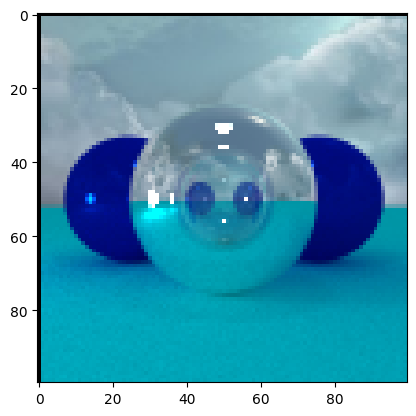

In [722]:
@nb.njit(parallel=True)
def render():

    camera = {
        "position": np.array([0.,0.,-2.],dtype=np.float64),
        # "orientation": [[1,0,0],[0,1,0],[0,0,1]],
        "d": 1,
        "w": 1,
        "h": 1,

        "canvas" : {
            "resolution":np.array((100,100),dtype=np.float64),
            "pixels": np.zeros((100,100,3), dtype=np.float64),
        }
    }


    spheres = np.array([[0.,0.,2.,1], [-1.5,0.,4.,1.], [1.5,0.,4.,1.], [0,-5001.,0.,5000.], [-5.,0,1,0.5], [0.,5.,1.,0.5]])
    lights = np.array([[0.,-0.5,0.,0.7]])

    # spheres = np.array([
    #     [1e5+1,40.8,81.6, 1e5],
    #     [-1e5+99,40.8,81.6, 1e5],
    #     [50,40.8,1e5, 1e5],
    #     [50,40.8,-1e5,1e5],
    #     [50,1e5,81.6, 1e5],
    #     [50,-1e5+81.6,81.6, 1e5],
    #     [27,16.5,47, 16.5],
    #     [73,16.5,78, 16.5],
    #     [50,681.6-.27,81.6, 600]
    # ])


    xmin = -int(camera['canvas']['resolution'][0]//2)+1
    xmax = int(camera['canvas']['resolution'][0]//2)
    ymin = -int(camera['canvas']['resolution'][1]//2)+1
    ymax = int(camera['canvas']['resolution'][1]//2)
    for x in nb.prange(xmin, xmax):
        for y in nb.prange(ymin, ymax):

            color = np.array([0,0,0], dtype=np.float64)
            n_samples = 1000

            for _ in nb.prange(n_samples):
                noise = 1
                x_ = x + (np.random.rand()-0.5)*noise
                y_ = y + (np.random.rand()-0.5)*noise

                # (x,y, resolution, w, h, d)
                D = canvas2world(x_,y_,camera['canvas']['resolution'], camera['w'], camera['h'], camera['d'])
                ray_origin = camera['position']
                ray_direction = np.array(D)

                # ray_origin, ray_direction, ray_tmin, ray_tmax, spheres, lights
                color += trace_ray(ray_origin, ray_direction, 0.001, np.inf, spheres, lights)

            color /= n_samples
            color_r = min(color[0], 1)
            color_g = min(color[1], 1)
            color_b = min(color[2], 1)

            color = np.array([color_r, color_g, color_b], dtype=np.float64)

            write_pixel(camera['canvas']['pixels'], camera['canvas']['resolution'], int(x), int(y), color)

    return camera['canvas']['pixels']


pixels = render()

plt.imshow(pixels.astype(float))